In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
aryashah2k_breast_ultrasound_images_dataset_path = kagglehub.dataset_download('aryashah2k/breast-ultrasound-images-dataset')

print('Data source import complete.')


Data source import complete.


<a id="2"></a>
# <p style="padding:10px;background-color:#e5a3a3 ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Importing libraries </p>

In [ ]:
# data preperation and processing
import os
import cv2
import random
import numpy as np

# data visulization
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go


# for model building
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


<a id="3"></a>
# <p style="padding:10px;background-color:#e5a3a3 ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">EDA </p>

In [ ]:
import kagglehub
import os

# Download dataset
dataset_path = kagglehub.dataset_download('aryashah2k/breast-ultrasound-images-dataset')

print("Actual dataset path:", dataset_path)

# Now explore its contents
for root, dirs, files in os.walk(dataset_path):
    print(root)
    for d in dirs:
        print(" -", d)
    for f in files[:5]:
        print(" -", f)
    break  # print only top-level to avoid clutter


Actual dataset path: /kaggle/input/breast-ultrasound-images-dataset
/kaggle/input/breast-ultrasound-images-dataset
 - Dataset_BUSI_with_GT


In [ ]:
data_path = os.path.join(dataset_path, "Dataset_BUSI_with_GT")


In [ ]:
image_counter = 0
mask_counter = 0

for folder_name in os.listdir(data_path):
    folder_content = os.path.join(data_path, folder_name)
    for image_name in os.listdir(folder_content):
        if '_mask' in image_name:
            mask_counter += 1
        else:
            image_counter += 1

    print(f"Images in {folder_name}: {image_counter}")
    print(f"Masks in {folder_name}: {mask_counter}")
    image_counter = 0
    mask_counter = 0


Images in benign: 437
Masks in benign: 454
Images in normal: 133
Masks in normal: 133
Images in malignant: 210
Masks in malignant: 211


<div style = 'border : 3px solid #e5a3a3; background-color:#f7e9e9;padding:10px; border-radius: 25px;'>

<strong> Notes  </strong>

 Some image has more than one mask in **benign** and **malignant**



In [ ]:
def vis_images(class_name, data_path=data_path, rows=2, cols=3, alpha=0.5):
    # to get all images path
    image_paths = sorted([
        os.path.join(data_path, class_name, img_name)
        for img_name in os.listdir(os.path.join(data_path, class_name))
        if "_mask" not in img_name
    ])
    # to get all masks path
    mask_paths = {
        os.path.basename(mask_name).replace("_mask", ""): os.path.join(data_path, class_name, mask_name)
        for mask_name in os.listdir(os.path.join(data_path, class_name)) if "_mask" in mask_name
    }

    # to get all images that has masks
    image_paths = [img for img in image_paths if os.path.basename(img) in mask_paths]

    # to ensure that we have enough images
    num_images = min(rows, len(image_paths))
    if num_images == 0:
        print(f"No valid images found for class: {class_name}")
        return

    # get random images to display
    random_images = random.sample(image_paths, num_images)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    axes = axes.reshape(rows, cols)

    for idx, img_path in enumerate(random_images):
        mask_path = mask_paths[os.path.basename(img_path)]

        # read image and mask
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))

        # convert mask to jet
        mask_colored = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
        mask_colored = cv2.cvtColor(mask_colored, cv2.COLOR_BGR2RGB)

        # add the image to the colored mask
        overlay = cv2.addWeighted(image, 1, mask_colored, alpha, 0)

        # original image
        axes[idx, 0].imshow(image)
        axes[idx, 0].set_title("Original Image")
        axes[idx, 0].axis("off")

        # mask
        axes[idx, 1].imshow(mask, cmap="gray")
        axes[idx, 1].set_title("Mask")
        axes[idx, 1].axis("off")

        # union (original image with the mask>>>>)
        axes[idx, 2].imshow(overlay)
        axes[idx, 2].set_title("Union Image")
        axes[idx, 2].axis("off")

    plt.tight_layout()
    plt.show()

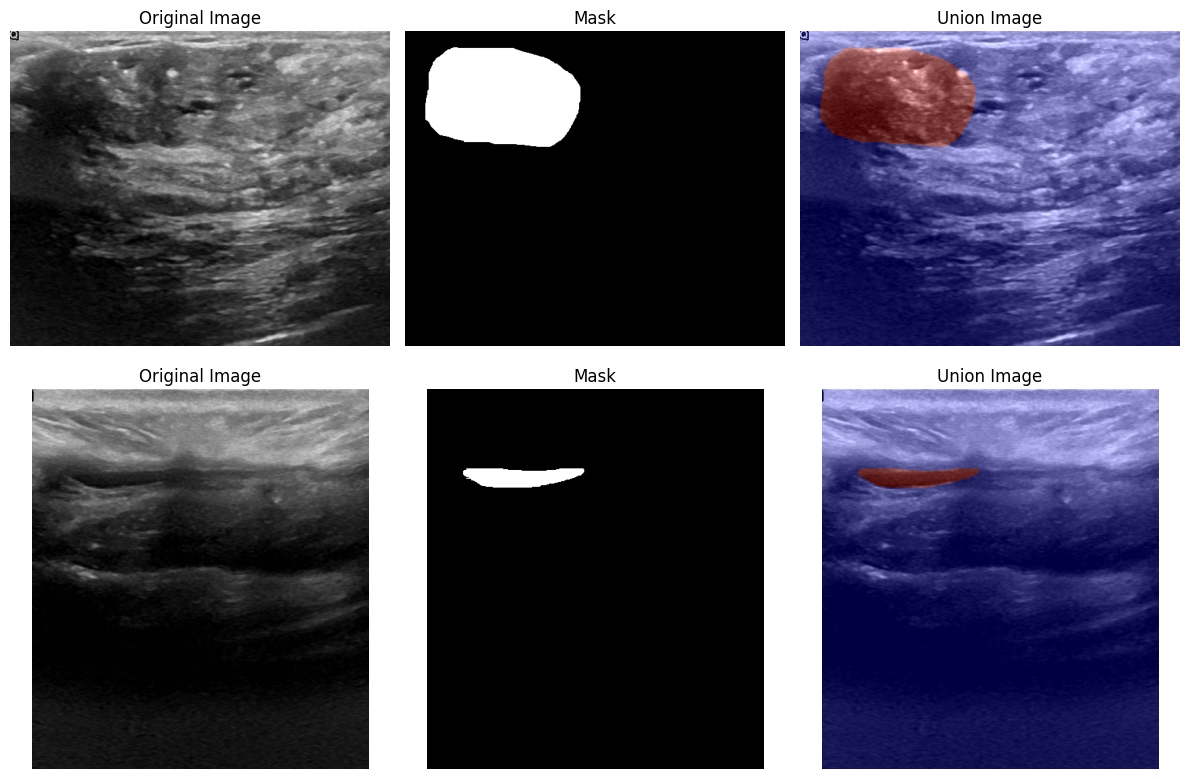

In [ ]:
#from benign class
vis_images (class_name="benign")

<div style = 'border : 3px solid #e5a3a3; background-color:#f7e9e9;padding:10px; border-radius: 25px;'>

<strong> Notes </strong>

For the class **benign**  the  image masks are located correctly



-----

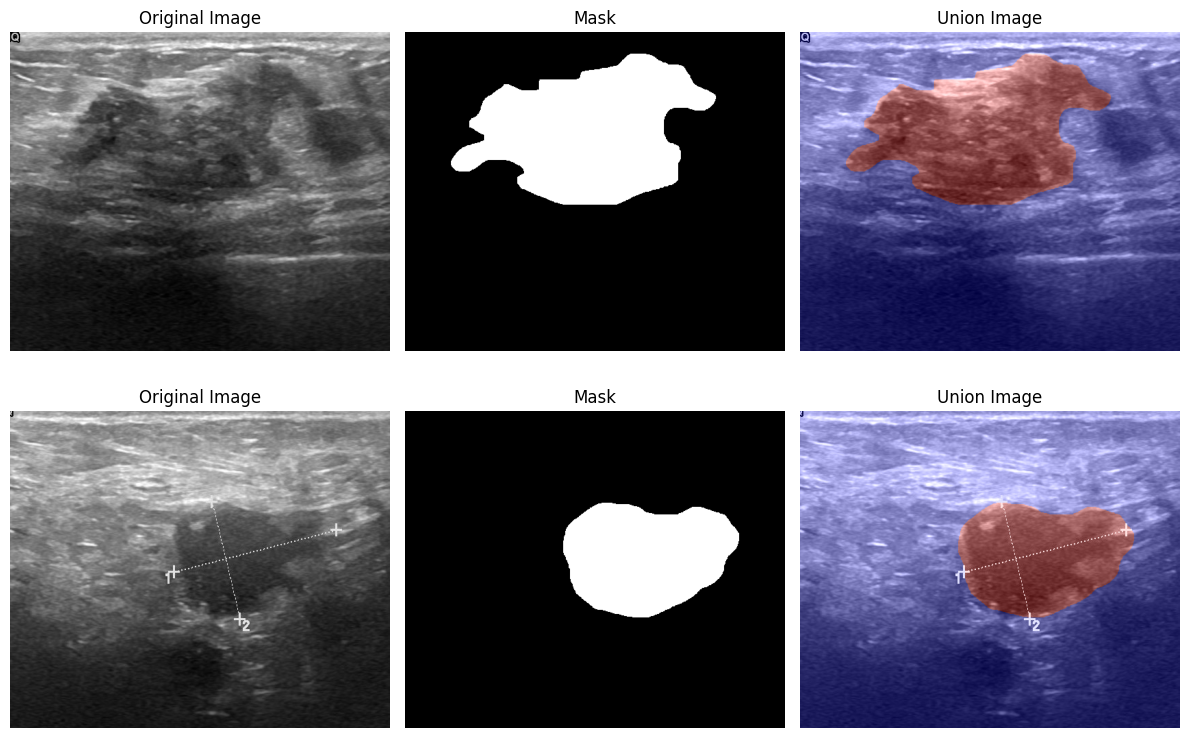

In [ ]:
#from malignant class
vis_images (class_name="malignant")

<div style = 'border : 3px solid #e5a3a3; background-color:#f7e9e9;padding:10px; border-radius: 25px;'>

<strong> Notes </strong>

For the class **malignant**  the image masks are located correctly



-------

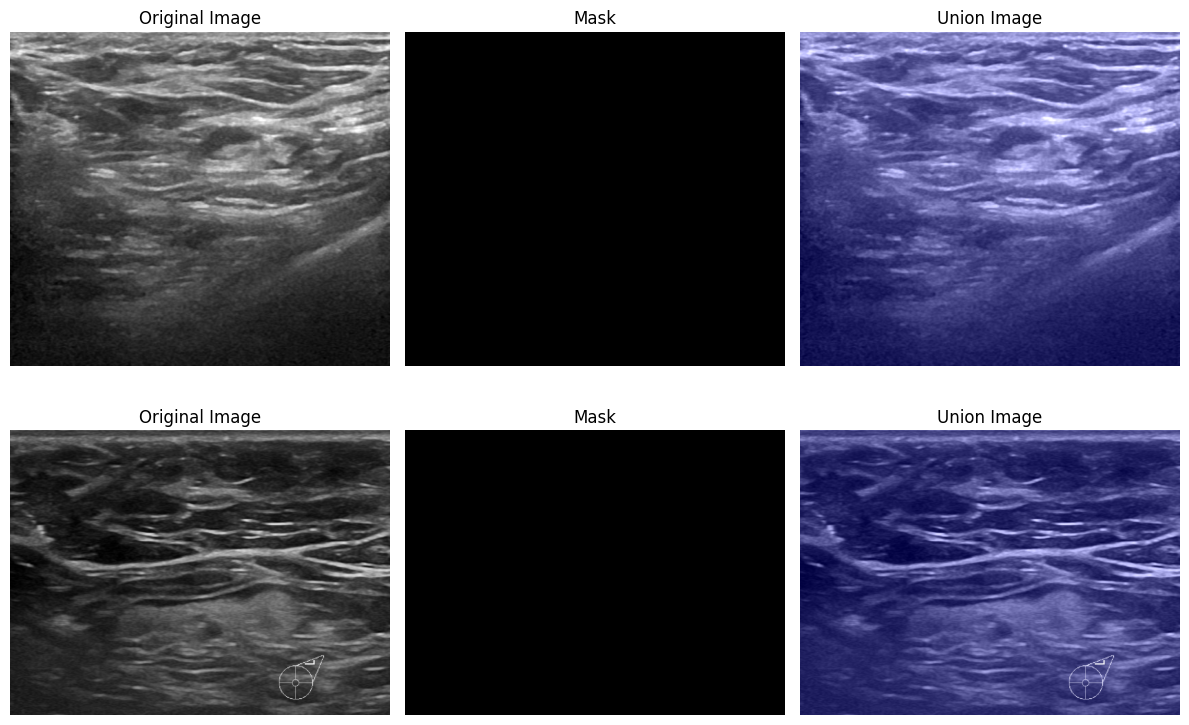

In [ ]:
#from normal class
vis_images (class_name="normal")

<div style = 'border : 3px solid #e5a3a3; background-color:#f7e9e9;padding:10px; border-radius: 25px;'>

<strong> Notes </strong>

For the class **normal** there are no image masks



---------

<a id="4"></a>
# <p style="padding:10px;background-color:#e5a3a3 ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Data preprocessing </p>




<div style = 'border : 3px solid #e5a3a3; background-color:#f7e9e9;padding:10px; border-radius: 25px;'>
    
Since the class **normal** does not contain masks, we will process only the data contained in both  **(benign and malignant)** and not-use **normal** calss

As we noted previously, there are some images that have more than one mask. Therefore, the best solution is to combine all the masks for a single image into an image that includes all the masks (an image that includes all the masks for multi masked image).

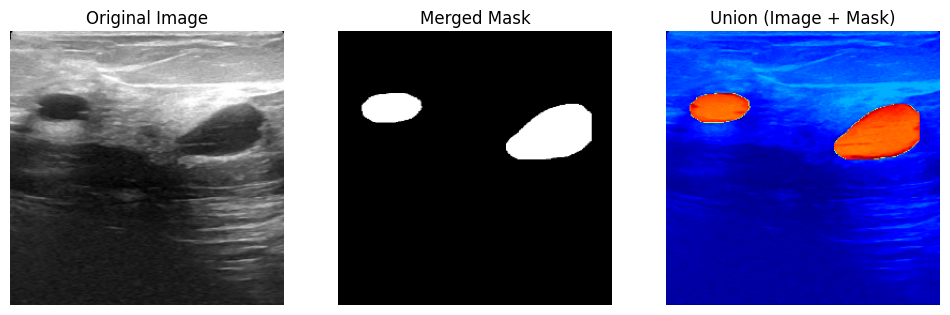

In [ ]:
# this example to show what i mean
# note in the image processing this process will be automated this example to clear the idea
image_path = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png" #this image from our dataset
mask_paths = [
    "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png",# the image has two masks as shown
    "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png"
]

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (256, 256))

mask_combined = np.zeros((256, 256), dtype=np.uint8) # balck image to add the masks on it
for mask_path in mask_paths:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask_combined = np.maximum(mask_combined, mask)# to combine the masks if an image has more than one mask

# easy code to display the image >>^^
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask_combined, cmap="gray")
plt.title("Merged Mask")
plt.axis("off")

union = cv2.addWeighted(image, 0.2, mask_combined, 0.5, 0)
plt.subplot(1, 3, 3)
plt.imshow(union, cmap="jet")
plt.title("Union (Image + Mask)")
plt.axis("off")

plt.show()


<div style = 'border : 3px solid #e5a3a3; background-color:#f7e9e9;padding:10px; border-radius: 25px;'>
    
🔘  As is clear, the masks for the image mentioned in the example have been combined into one image, and this is what is required

In [ ]:
def load_data(dataset_path):
    images = []  # List to store preprocessed images
    masks = []   # List to store corresponding lesion masks
    labels = []  # List to store class labels (0: benign, 1: malignant, 2: normal)

    label_map = {"benign": 0, "malignant": 1, "normal": 2}  # Added "normal" category

    for category in ["benign", "malignant", "normal"]:
        category_path = os.path.join(dataset_path, category)

        # Get all image filenames that are not masks
        image_files = [f for f in os.listdir(category_path) if "_mask" not in f]

        for img_file in image_files:
            img_path = os.path.join(category_path, img_file)
            base_name = img_file.split(".")[0]

            # ----------- Process the Image -----------
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (256, 256))
            img = cv2.GaussianBlur(img, (3, 3), 0)
            img = img / 255.0
            images.append(img)

            # ----------- Process the Mask -----------
            if category != "normal":
                mask_paths = sorted([
                    os.path.join(category_path, f)
                    for f in os.listdir(category_path)
                    if f.startswith(base_name + "_mask")
                ])

                mask_combined = np.zeros((256, 256), dtype=np.uint8)
                for mask_path in mask_paths:
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.resize(mask, (256, 256))
                    mask_combined = np.maximum(mask_combined, mask)
                masks.append(mask_combined / 255.0)
            else:
                # Normal images have no mask — use a blank one
                masks.append(np.zeros((256, 256), dtype=np.float32))

            labels.append(label_map[category])

    # Convert to numpy arrays
    images = np.array(images).reshape(-1, 256, 256, 1)
    masks = np.array(masks).reshape(-1, 256, 256, 1)
    labels = np.array(labels)

    return images, masks, labels


In [ ]:
# Load dataset
dataset_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

# Load images (X), masks (Y), and labels (ignored here using '_')
X, Y, _ = load_data(dataset_path)  # X: ultrasound images, Y: lesion masks

# Split dataset into training and testing sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Shapes:")
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test :", X_test.shape)
print("Y_test :", Y_test.shape)


Shapes:
X_train: (624, 256, 256, 1)
Y_train: (624, 256, 256, 1)
X_test : (156, 256, 256, 1)
Y_test : (156, 256, 256, 1)


In [ ]:
X_train.shape , Y_train.shape # Batch_size , image dims(h,w) , n_channels

((624, 256, 256, 1), (624, 256, 256, 1))

In [ ]:
X_test.shape , Y_test.shape

((156, 256, 256, 1), (156, 256, 256, 1))

<a id="5"></a>
# <p style="padding:10px;background-color:#e5a3a3 ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Model Building </p>





<div style = 'border : 3px solid #e5a3a3; background-color:#f7e9e9;padding:10px; border-radius: 25px;'>


🔘 **U-Net** is a convolutional neural network (CNN) architecture specifically designed for **semantic segmentation tasks**. Initially developed for biomedical image segmentation, U-Net has proven to be highly effective in tasks requiring pixel-level classification, where the goal is to assign a label to each pixel in an image. The architecture consists of two main parts: an encoder and a decoder, which are connected through skip connections.

🔘 **Encoder:** The encoder (also known as the contracting path) progressively **reduces the spatial dimensions of the input image using convolutional layers** followed by pooling layers. This captures high-level features and abstracts the image.

🔘 **Decoder:** The decoder (or expansive path) upsamples the feature maps to **reconstruct the spatial dimensions**. It combines the upsampled features with the corresponding feature maps from the encoder via skip connections. This helps the network retain spatial information, which is crucial for precise segmentation.

🔘 **Skip Connections:** These connections between the encoder and decoder allow the network to retain fine-grained details and context, which is essential for accurate segmentation, particularly at the boundaries of objects.



<div style = 'border : 3px solid #e5a3a3; background-color:#f7e9e9;padding:10px; border-radius: 25px;'>

**Why Use U-Net for Breast Cancer Segmentation?**

  - High Accuracy in Semantic Segmentation: U-Net is widely regarded for its performance in tasks involving the precise segmentation of structures, which is critical in medical image analysis, such as detecting tumors in breast ultrasound images.

  - Efficient with Limited Data: U-Net's design makes it well-suited for scenarios where the available data is limited. This is important in medical imaging, where annotated data is often scarce.

  - Preserves Spatial Information: The skip connections in U-Net help preserve spatial information throughout the encoding-decoding process, making it more effective in segmenting complex structures with varying shapes and sizes, such as tumors, while maintaining high resolution at the pixel level.

  - Established Success in Medical Imaging: U-Net has been extensively tested and utilized in various medical image segmentation tasks, including breast cancer detection, proving its robustness and reliability in real-world medical applications.

- Try Different Variation

In [ ]:
checkpoint = ModelCheckpoint('best_model.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)


early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=15,
                               restore_best_weights=True,
                               verbose=1)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Save the model that has the best validation SEGMENTATION loss
checkpoint = ModelCheckpoint('best_multi_task_model.keras',
                             monitor='val_seg_output_loss',  # Monitor segmentation head loss
                             save_best_only=True,
                             verbose=1)

# Stop training if classification accuracy doesn't improve
early_stopping = EarlyStopping(monitor='val_cls_output_accuracy',  # Monitor classification accuracy
                               patience=15,
                               restore_best_weights=True,
                               verbose=1)


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def load_data(dataset_path):
    images = []  # List to store preprocessed images
    masks = []   # List to store corresponding lesion masks
    labels = []  # List to store class labels (0: benign, 1: malignant, 2: normal)

    label_map = {"benign": 0, "malignant": 1, "normal": 2}  # Added "normal" category

    for category in ["benign", "malignant", "normal"]:
        category_path = os.path.join(dataset_path, category)

        # Get all image filenames that are not masks
        image_files = [f for f in os.listdir(category_path) if "_mask" not in f]

        for img_file in image_files:
            img_path = os.path.join(category_path, img_file)
            base_name = img_file.split(".")[0]

            # ----------- Process the Image -----------
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (256, 256))
            img = cv2.GaussianBlur(img, (3, 3), 0)
            img = img / 255.0
            images.append(img)

            # ----------- Process the Mask -----------
            if category != "normal":
                mask_paths = sorted([
                    os.path.join(category_path, f)
                    for f in os.listdir(category_path)
                    if f.startswith(base_name + "_mask")
                ])

                mask_combined = np.zeros((256, 256), dtype=np.uint8)
                for mask_path in mask_paths:
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.resize(mask, (256, 256))
                    mask_combined = np.maximum(mask_combined, mask)
                masks.append(mask_combined / 255.0)
            else:
                # Normal images have no mask — use a blank one
                masks.append(np.zeros((256, 256), dtype=np.float32))

            labels.append(label_map[category])

    # Convert to numpy arrays
    images = np.array(images).reshape(-1, 256, 256, 1)
    masks = np.array(masks).reshape(-1, 256, 256, 1)
    labels = np.array(labels)

    return images, masks, labels



# Load dataset
dataset_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
X, Y, class_labels = load_data(dataset_path)

# One-hot encode class labels (0 or 1 -> [1, 0] or [0, 1])
Y_class = to_categorical(class_labels, num_classes=3)

# Train-test split
X_train, X_test, Y_train, Y_test, Y_class_train, Y_class_test = train_test_split(
    X, Y, Y_class, test_size=0.2, random_state=42
)

print("Shapes:")
print("X_train      :", X_train.shape)
print("Y_train      :", Y_train.shape)
print("Y_class_train:", Y_class_train.shape)
print("X_test       :", X_test.shape)
print("Y_test       :", Y_test.shape)
print("Y_class_test :", Y_class_test.shape)


Shapes:
X_train      : (624, 256, 256, 1)
Y_train      : (624, 256, 256, 1)
Y_class_train: (624, 3)
X_test       : (156, 256, 256, 1)
Y_test       : (156, 256, 256, 1)
Y_class_test : (156, 3)


In [ ]:
from tensorflow.keras import layers, models

def build_multi_output_unet(input_shape=(256, 256, 1)):
    inputs = layers.Input(shape=input_shape)

    # --- U-Net Encoding Path ---
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # --- Bottleneck ---
    bn = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)

    # --- U-Net Decoding Path ---
    u1 = layers.UpSampling2D((2, 2))(bn)
    m1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(m1)

    u2 = layers.UpSampling2D((2, 2))(c3)
    m2 = layers.Concatenate()([u2, c1])
    c4 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(m2)

    # --- Segmentation Output ---
    seg_output = layers.Conv2D(1, (1, 1), activation='sigmoid', name='seg_output')(c4)

    # --- Classification Output ---
    flat = layers.GlobalAveragePooling2D()(bn)  # Use bottleneck features
    dense1 = layers.Dense(64, activation='relu')(flat)
    cls_output = layers.Dense(3, activation='softmax', name='cls_output')(dense1)

    model = models.Model(inputs=inputs, outputs=[seg_output, cls_output])
    return model

In [ ]:
model = build_multi_output_unet()

model.compile(
    optimizer='adam',
    loss={
        'seg_output': 'binary_crossentropy',
        'cls_output': 'categorical_crossentropy'
    },
    metrics={
        'seg_output': ['accuracy'],
        'cls_output': ['accuracy']
    }
)


In [ ]:
history = model.fit(
    X_train,
    {'seg_output': Y_train, 'cls_output': Y_class_train},
    validation_data=(X_test, {'seg_output': Y_test, 'cls_output': Y_class_test}),
    epochs=100,
    batch_size=8,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/100
77/78 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - cls_output_accuracy: 0.5533 - cls_output_loss: 1.0062 - loss: 1.3959 - seg_output_accuracy: 0.9222 - seg_output_loss: 0.3896
Epoch 1: val_loss improved from inf to 1.26312, saving model to best_model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - cls_output_accuracy: 0.5534 - cls_output_loss: 1.0062 - loss: 1.3939 - seg_output_accuracy: 0.9222 - seg_output_loss: 0.3878 - val_cls_output_accuracy: 0.5385 - val_cls_output_loss: 0.9904 - val_loss: 1.2631 - val_seg_output_accuracy: 0.9239 - val_seg_output_loss: 0.2635
Epoch 2/100
 3/78 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - cls_output_accuracy: 0.7083 - cls_output_loss: 0.8508 - loss: 1.0718 - seg_output_accuracy: 0.9409 - seg_output_loss: 0.2210

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: cls_output_accuracy,cls_output_loss,loss,seg_output_accuracy,seg_output_loss,val_cls_output_accuracy,val_cls_output_loss,val_loss,val_seg_output_accuracy,val_seg_output_loss
  current = self.get_monitor_value(logs)


77/78 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - cls_output_accuracy: 0.5764 - cls_output_loss: 0.9616 - loss: 1.2171 - seg_output_accuracy: 0.9269 - seg_output_loss: 0.2555
Epoch 2: val_loss improved from 1.26312 to 1.24945, saving model to best_model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - cls_output_accuracy: 0.5761 - cls_output_loss: 0.9620 - loss: 1.2179 - seg_output_accuracy: 0.9267 - seg_output_loss: 0.2559 - val_cls_output_accuracy: 0.5385 - val_cls_output_loss: 0.9859 - val_loss: 1.2495 - val_seg_output_accuracy: 0.9239 - val_seg_output_loss: 0.2529
Epoch 3/100
77/78 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - cls_output_accuracy: 0.5453 - cls_output_loss: 0.9904 - loss: 1.2686 - seg_output_accuracy: 0.9148 - seg_output_loss: 0.2782
Epoch 3: val_loss did not improve from 1.24945
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - cls_output_accuracy: 0.5458 - cls_output_loss: 0.9900 - loss: 1.2679 - seg_output_accuracy: 0.9149 - seg_output_loss: 0.2779 - val_cls_output_accuracy: 0.5385 - val_c

<a id="6"></a>
# <p style="padding:10px;background-color:#e5a3a3 ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Model Evaluation 📈</p>

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# ---------- SEGMENTATION METRICS ---------- #
def mean_iou(y_true, y_pred):
    y_pred = (y_pred > 0.5).astype(np.uint8)
    y_true = y_true.astype(np.uint8)
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 1.0

def dice_coefficient(y_true, y_pred):
    y_pred = (y_pred > 0.5).astype(np.uint8)
    y_true = y_true.astype(np.uint8)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-7)

def pixel_accuracy(y_true, y_pred):
    y_pred = (y_pred > 0.5).astype(np.uint8)
    y_true = y_true.astype(np.uint8)
    correct = (y_true == y_pred).sum()
    total = np.prod(y_true.shape)
    return correct / total


In [ ]:
# Predict outputs
Y_pred_seg, Y_pred_cls = model.predict(X_test)

# Round segmentation output
Y_pred_seg_binary = (Y_pred_seg > 0.5).astype(np.uint8)

# Convert one-hot encoded labels to class indices
Y_class_test_labels = np.argmax(Y_class_test, axis=1)
Y_pred_cls_labels = np.argmax(Y_pred_cls, axis=1)


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 791ms/step


In [ ]:
iou_scores = [mean_iou(y_true, y_pred) for y_true, y_pred in zip(Y_test, Y_pred_seg_binary)]
dice_scores = [dice_coefficient(y_true, y_pred) for y_true, y_pred in zip(Y_test, Y_pred_seg_binary)]
pixel_accuracies = [pixel_accuracy(y_true, y_pred) for y_true, y_pred in zip(Y_test, Y_pred_seg_binary)]

print("Segmentation Metrics:")
print(f"Mean IoU        : {np.mean(iou_scores):.4f}")
print(f"Dice Coefficient: {np.mean(dice_scores):.4f}")
print(f"Pixel Accuracy  : {np.mean(pixel_accuracies):.4f}")


Segmentation Metrics:
Mean IoU        : 0.1918
Dice Coefficient: 0.2277
Pixel Accuracy  : 0.9299


In [ ]:
print("\nClassification Metrics:")
print(f"Accuracy : {accuracy_score(Y_class_test_labels, Y_pred_cls_labels):.4f}")
print(f"Precision: {precision_score(Y_class_test_labels, Y_pred_cls_labels, average='weighted'):.4f}")
print(f"Recall   : {recall_score(Y_class_test_labels, Y_pred_cls_labels, average='weighted'):.4f}")
print(f"F1-Score : {f1_score(Y_class_test_labels, Y_pred_cls_labels, average='weighted'):.4f}")

# Optional: Detailed report
print("\nClassification Report:")
print(classification_report(Y_class_test_labels, Y_pred_cls_labels, target_names=['Benign', 'Malignant', 'Normal'])) #Added Normal


Classification Metrics:
Accuracy : 0.6859
Precision: 0.7165
Recall   : 0.6859
F1-Score : 0.6715

Classification Report:
              precision    recall  f1-score   support

      Benign       0.72      0.80      0.76        84
   Malignant       0.58      0.72      0.65        43
      Normal       0.90      0.31      0.46        29

    accuracy                           0.69       156
   macro avg       0.74      0.61      0.62       156
weighted avg       0.72      0.69      0.67       156



In [ ]:
# Save the trained model
model.save("Latest_breast_ultrasound_multitask_model.h5")
print("Model saved successfully.")


Model saved successfully.


In [ ]:
# Build the model
model = build_multi_output_unet()

# Print the model architecture
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 256, 256,  │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 128, 128,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ up_sampling2d_2[… │
│ (Concatenate)       │ 96)               │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │     27,680 │ concatenate_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 256, 256,  │          0 │ conv2d_8[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 256, 256,  │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 48)               │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_7[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │      6,928 │ concatenate_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seg_output (Conv2D) │ (None, 256, 256,  │         17 │ conv2d_9[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls_output (Dense)  │ (None, 3)         │        195 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 62,276 (243.27 KB)

 Trainable params: 62,276 (243.27 KB)

 Non-trainable params: 0 (0.00 B)

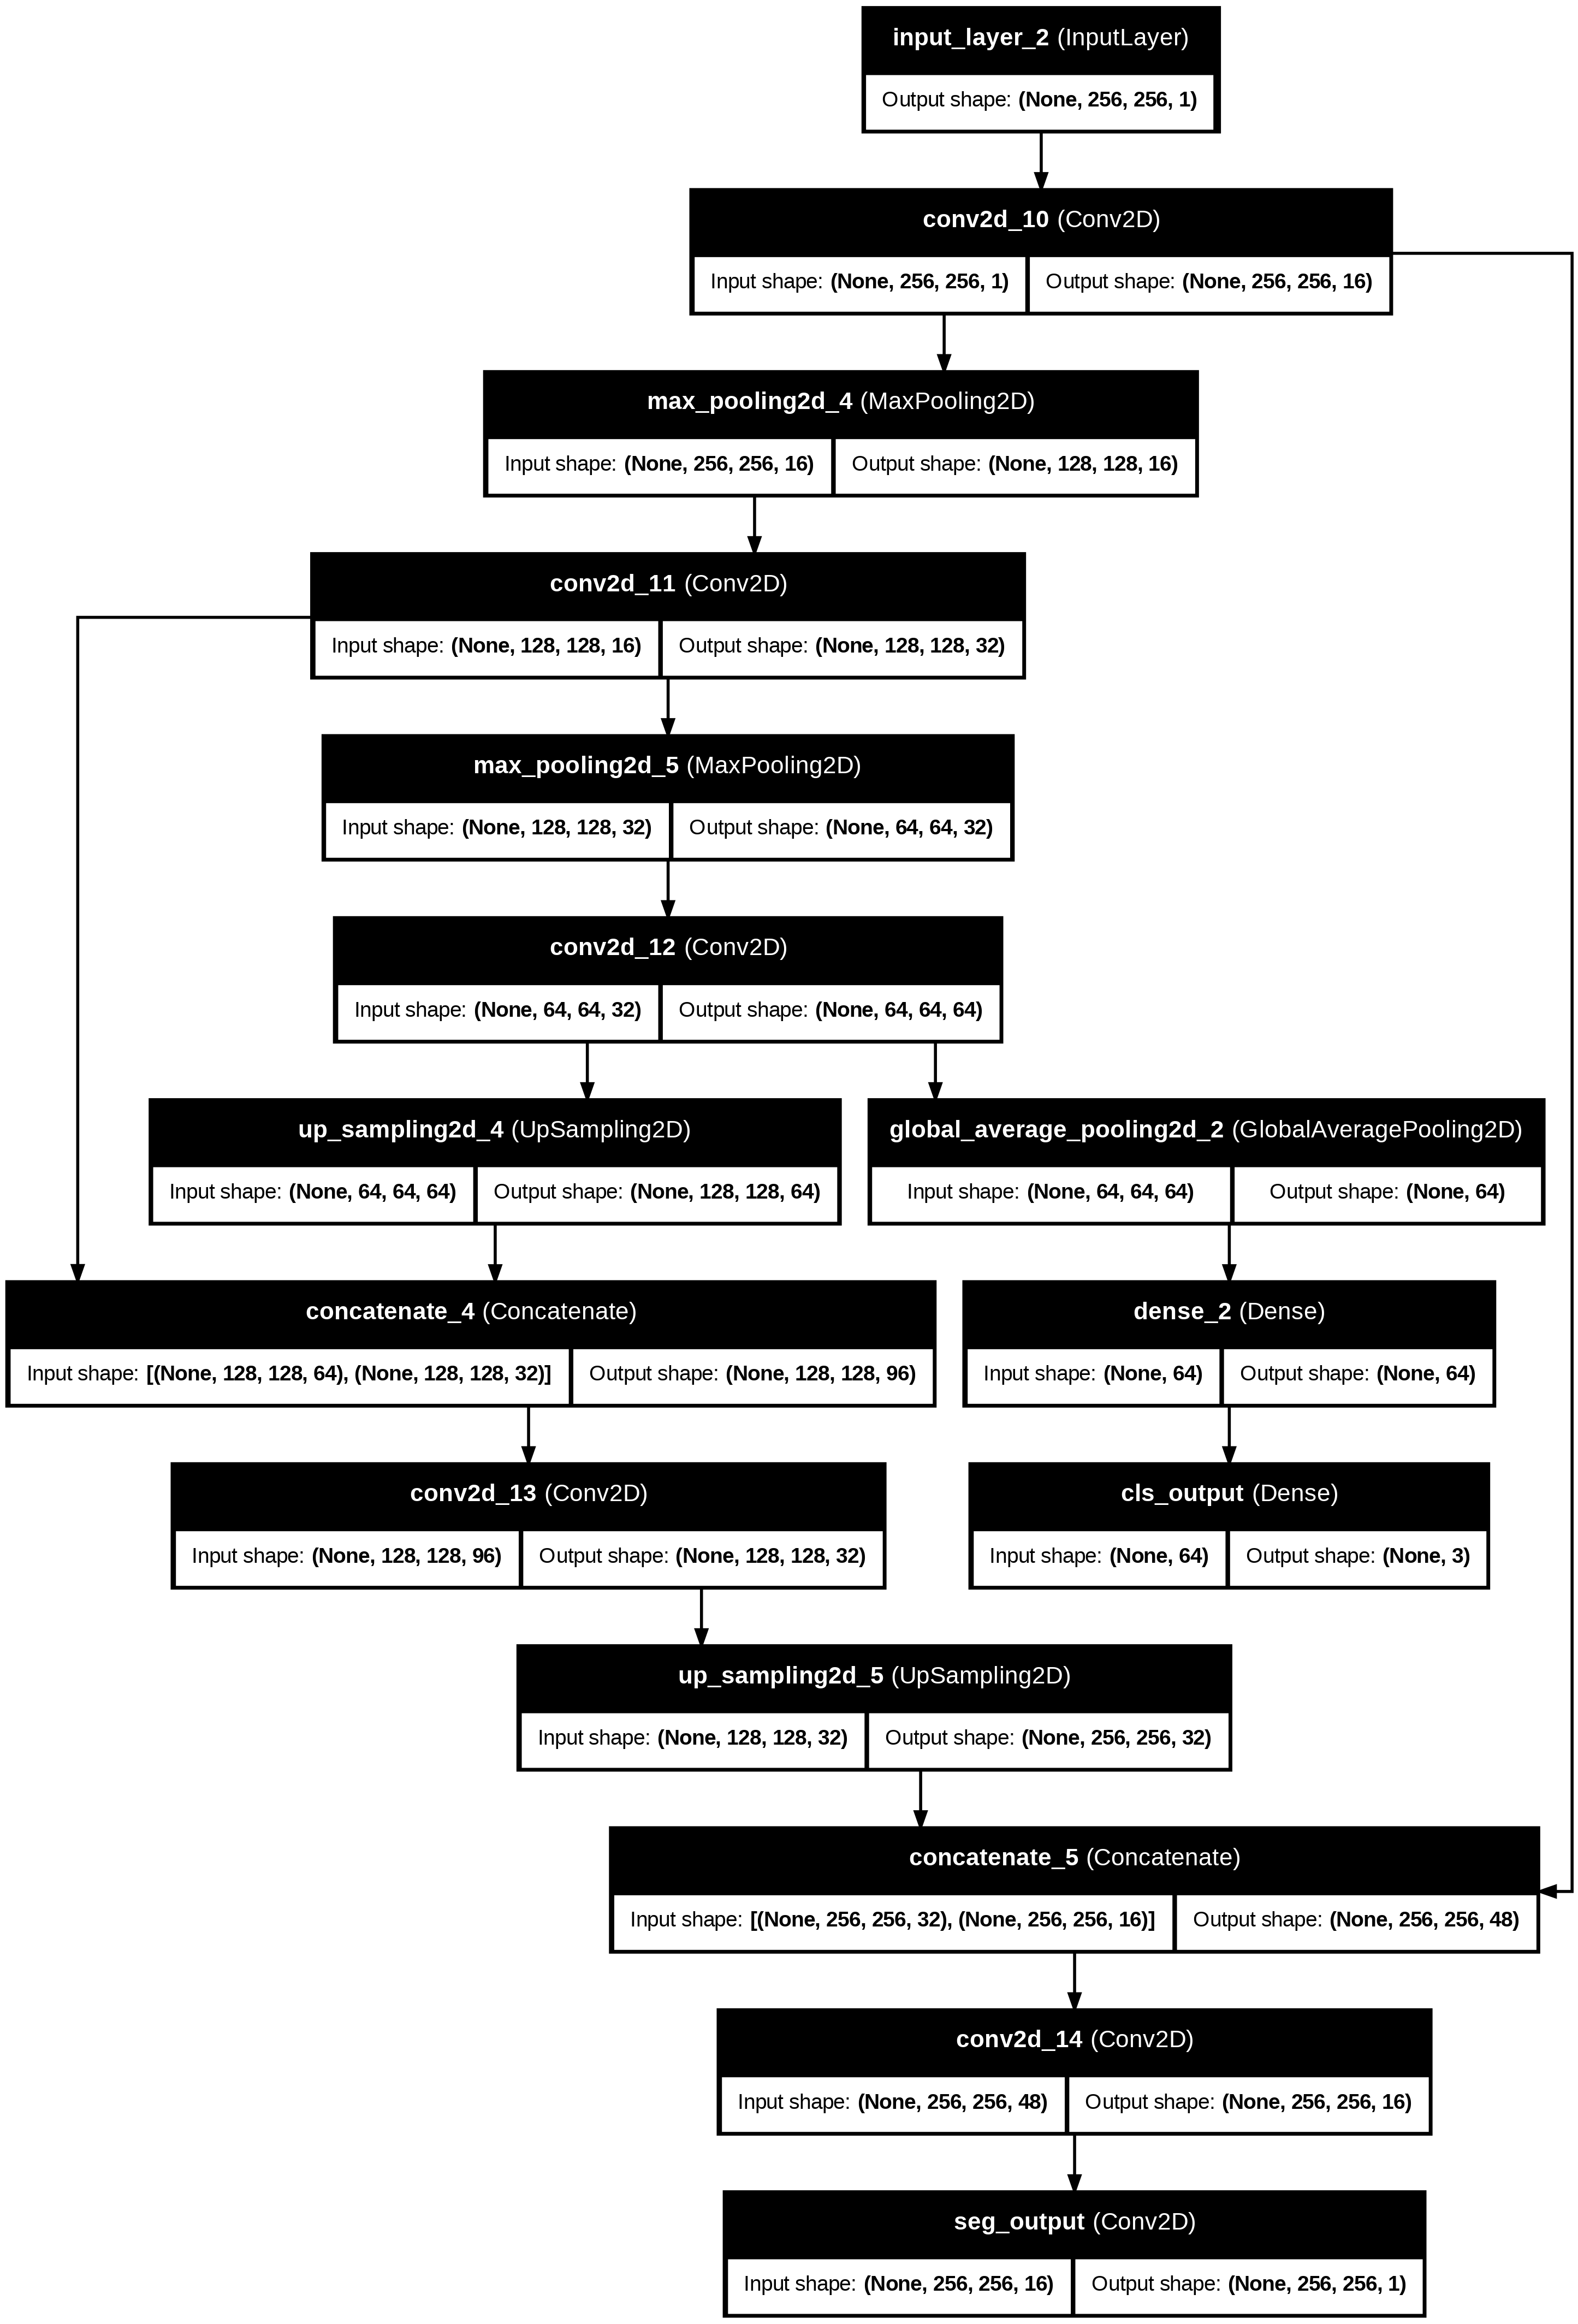

In [ ]:
from tensorflow.keras.utils import plot_model

# Build the model instance
model = build_multi_output_unet()

# Plot and save the model architecture
plot_model(model, to_file='build_multi_output_unet.png', show_shapes=True, show_layer_names=True)


# Final Model Test with Random Image

Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


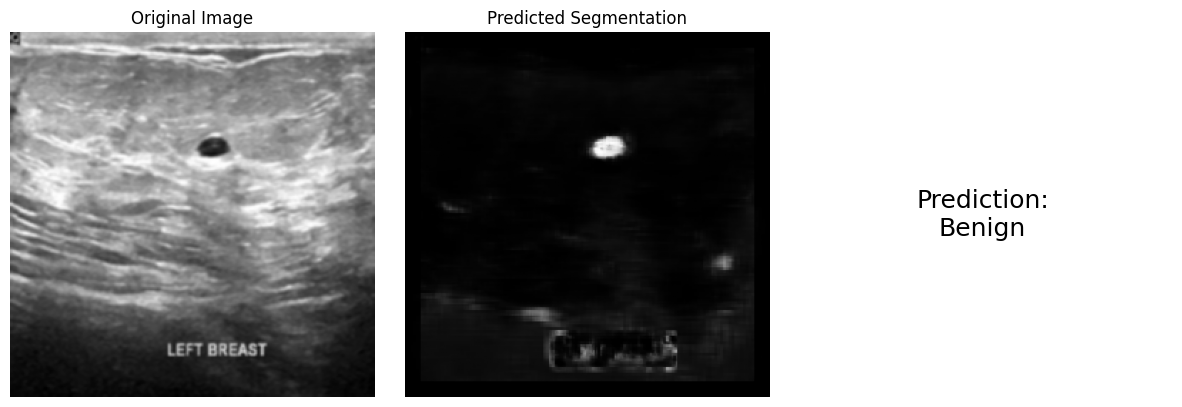

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the saved model (Updated to the new model filename)
model = load_model("Latest_breast_ultrasound_multitask_model.h5")
print("Model loaded successfully.")

# ----------- STEP 1: Load and preprocess external image -----------
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = img / 255.0
    img = img.reshape(1, 256, 256, 1)
    return img

# ----------- STEP 2: Predict segmentation and class -----------
def predict_external_image(image_path):
    img_input = preprocess_image(image_path)
    pred_mask, pred_class = model.predict(img_input)

    pred_mask = pred_mask[0, :, :, 0]  # remove batch dimension
    pred_class_label = np.argmax(pred_class[0])

    # Updated class names to include Normal
    class_names = ["Benign", "Malignant", "Normal"]
    class_name = class_names[pred_class_label]

    # ----------- STEP 3: Display results -----------
    plt.figure(figsize=(12, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(img_input[0, :, :, 0], cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Segmentation")
    plt.axis("off")

    # Classification (Updated to display the correct class)
    plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, f"Prediction:\n{class_name}", fontsize=18,
             horizontalalignment='center', verticalalignment='center')
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# ----------- STEP 4: Call function with your image path -----------
image_path = "/content/01.png"  # <-- CHANGE THIS TO YOUR IMAGE
predict_external_image(image_path)

Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


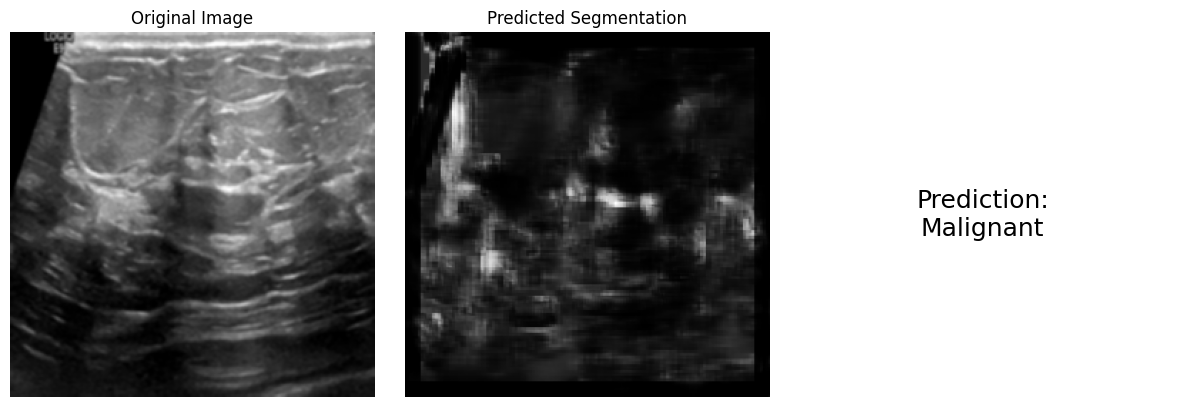

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the saved model (Updated to the new model filename)
model = load_model("Latest_breast_ultrasound_multitask_model.h5")
print("Model loaded successfully.")

# ----------- STEP 1: Load and preprocess external image -----------
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = img / 255.0
    img = img.reshape(1, 256, 256, 1)
    return img

# ----------- STEP 2: Predict segmentation and class -----------
def predict_external_image(image_path):
    img_input = preprocess_image(image_path)
    pred_mask, pred_class = model.predict(img_input)

    pred_mask = pred_mask[0, :, :, 0]  # remove batch dimension
    pred_class_label = np.argmax(pred_class[0])

    # Updated class names to include Normal
    class_names = ["Benign", "Malignant", "Normal"]
    class_name = class_names[pred_class_label]

    # ----------- STEP 3: Display results -----------
    plt.figure(figsize=(12, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(img_input[0, :, :, 0], cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Segmentation")
    plt.axis("off")

    # Classification (Updated to display the correct class)
    plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, f"Prediction:\n{class_name}", fontsize=18,
             horizontalalignment='center', verticalalignment='center')
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# ----------- STEP 4: Call function with your image path -----------
image_path = "/content/02.png"  # <-- CHANGE THIS TO YOUR IMAGE
predict_external_image(image_path)

Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


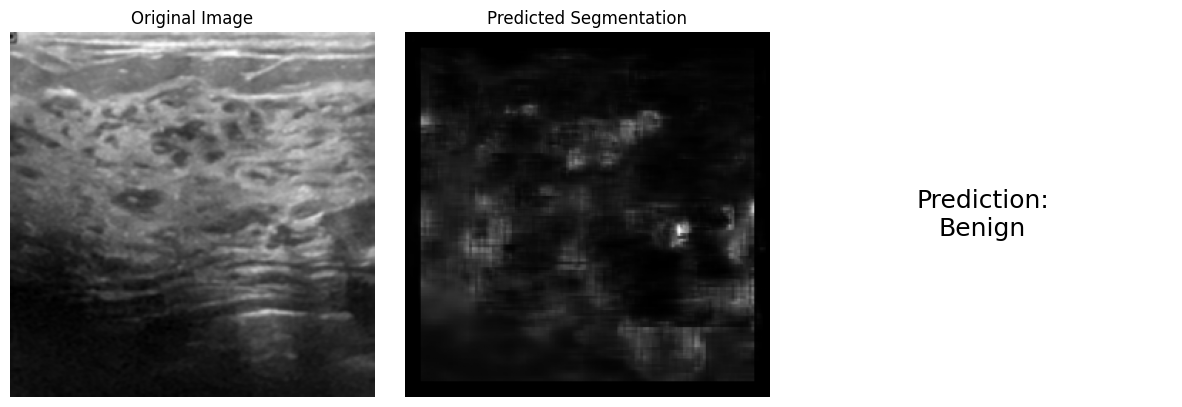

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the saved model (Updated to the new model filename)
model = load_model("Latest_breast_ultrasound_multitask_model.h5")
print("Model loaded successfully.")

# ----------- STEP 1: Load and preprocess external image -----------
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = img / 255.0
    img = img.reshape(1, 256, 256, 1)
    return img

# ----------- STEP 2: Predict segmentation and class -----------
def predict_external_image(image_path):
    img_input = preprocess_image(image_path)
    pred_mask, pred_class = model.predict(img_input)

    pred_mask = pred_mask[0, :, :, 0]  # remove batch dimension
    pred_class_label = np.argmax(pred_class[0])

    # Updated class names to include Normal
    class_names = ["Benign", "Malignant", "Normal"]
    class_name = class_names[pred_class_label]

    # ----------- STEP 3: Display results -----------
    plt.figure(figsize=(12, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(img_input[0, :, :, 0], cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Segmentation")
    plt.axis("off")

    # Classification (Updated to display the correct class)
    plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, f"Prediction:\n{class_name}", fontsize=18,
             horizontalalignment='center', verticalalignment='center')
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# ----------- STEP 4: Call function with your image path -----------
image_path = "/content/03.png"  # <-- CHANGE THIS TO YOUR IMAGE
predict_external_image(image_path)

Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


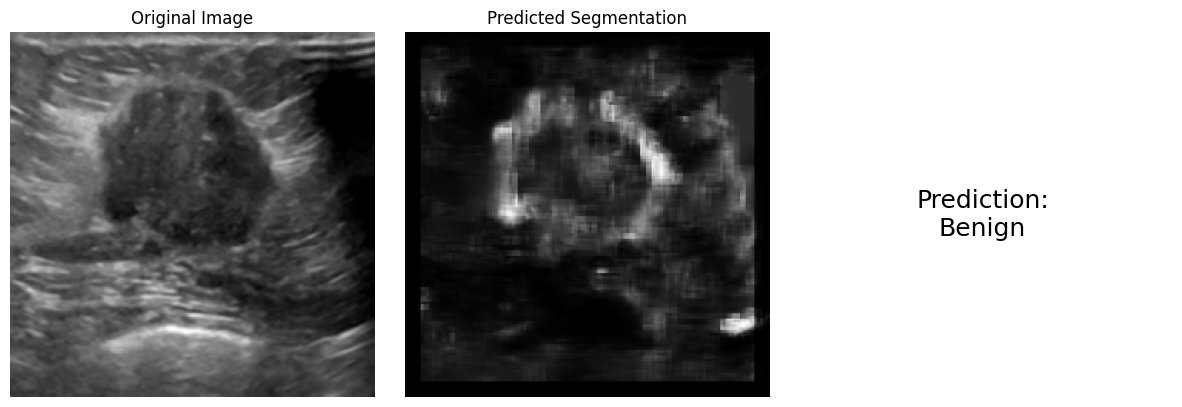

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the saved model (Updated to the new model filename)
model = load_model("Latest_breast_ultrasound_multitask_model.h5")
print("Model loaded successfully.")

# ----------- STEP 1: Load and preprocess external image -----------
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = img / 255.0
    img = img.reshape(1, 256, 256, 1)
    return img

# ----------- STEP 2: Predict segmentation and class -----------
def predict_external_image(image_path):
    img_input = preprocess_image(image_path)
    pred_mask, pred_class = model.predict(img_input)

    pred_mask = pred_mask[0, :, :, 0]  # remove batch dimension
    pred_class_label = np.argmax(pred_class[0])

    # Updated class names to include Normal
    class_names = ["Benign", "Malignant", "Normal"]
    class_name = class_names[pred_class_label]

    # ----------- STEP 3: Display results -----------
    plt.figure(figsize=(12, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(img_input[0, :, :, 0], cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Segmentation")
    plt.axis("off")

    # Classification (Updated to display the correct class)
    plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, f"Prediction:\n{class_name}", fontsize=18,
             horizontalalignment='center', verticalalignment='center')
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# ----------- STEP 4: Call function with your image path -----------
image_path = "/content/04.png"  # <-- CHANGE THIS TO YOUR IMAGE
predict_external_image(image_path)

###